In [1]:
#https://github.com/cdt15/lingam/blob/master/lingam/var_lingam.py

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
pip install lingam graphviz statsmodels

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 20.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.4/134.4 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.6/84.6 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.3/94.3 kB 5.2 MB/s eta 0:00:00
  Created wheel for semopy: filename=semopy-2.3.11-py3-none-any.whl size=1659682 sha256=ee032969f3aaf0575ebd1d96da269c4869711b50998331f211e3bcbe6a3eda06
  Stored in directory: /root/.cache/pip/wheels/c6/24/8b/be911b059a61f490f38425eb19bf2fed470a5ead97228e8255
Successfully built semopy


In [4]:
"""
Python implementation of the LiNGAM algorithms.
The LiNGAM Project: https://sites.google.com/view/sshimizu06/lingam
"""
import itertools
import warnings

from sklearn.linear_model import LinearRegression
from sklearn.utils import check_array, resample
from statsmodels.tsa.vector_ar.var_model import VAR

# Corrected imports
from lingam.base import _BaseLiNGAM
from lingam.bootstrap import BootstrapResult
from lingam.direct_lingam import DirectLiNGAM
from lingam.hsic import hsic_test_gamma
from lingam.utils import predict_adaptive_lasso, find_all_paths, calculate_total_effect


class VARLiNGAM:
    """Implementation of VAR-LiNGAM Algorithm [1]_

    References
    ----------
    .. [1] Aapo Hyvärinen, Kun Zhang, Shohei Shimizu, Patrik O. Hoyer.
       Estimation of a Structural Vector Autoregression Model Using Non-Gaussianity.
       Journal of Machine Learning Research, 11: 1709-1731, 2010.
    """

    def __init__(
        self,
        lags=1,
        prune=True,
        criterion=None,  ##########
        alpha_lasso=0.1,    #############
        ar_coefs=None,
        lingam_model=None,
        random_state=None,
    ):
        """Construct a VARLiNGAM model.

        Parameters
        ----------
        lags : int, optional (default=1)
            Number of lags.
        criterion : {‘aic’, ‘fpe’, ‘hqic’, ‘bic’, None}, optional (default='bic')
            Criterion to decide the best lags within ``lags``.
            Searching the best lags is disabled if ``criterion`` is ``None``.
        prune : boolean, optional (default=True)
            Whether to prune the adjacency matrix of lags.
        ar_coefs : array-like, optional (default=None)
            Coefficients of AR model. Estimating AR model is skipped if specified ``ar_coefs``.
            Shape must be (``lags``, n_features, n_features).
        lingam_model : lingam object inherits 'lingam._BaseLiNGAM', optional (default=None)
            LiNGAM model for causal discovery. If None, DirectLiNGAM algorithm is selected.
        random_state : int, optional (default=None)
            ``random_state`` is the seed used by the random number generator.
        """
        self._lags = lags
        self._criterion = criterion
        self._prune = prune
        self._ar_coefs = (
            check_array(ar_coefs, allow_nd=True) if ar_coefs is not None else None
        )
        self._lingam_model = lingam_model
        self._random_state = random_state
        self.alpha_lasso = alpha_lasso          ########################

    def fit(self, X):
        """Fit the model to X.

        Parameters
        ----------
        X: array-like, shape (n_samples, n_features)
            Training data, where ``n_samples`` is the number of samples
            and ``n_features`` is the number of features.

        returns
        -------
        self : object
            Returns the instance itself.
        """
        self._causal_order = None
        self._adjacency_matrices = None

        X = check_array(X)

        lingam_model = self._lingam_model
        if lingam_model is None:
            lingam_model = DirectLiNGAM()
        elif not isinstance(lingam_model, _BaseLiNGAM):
            raise ValueError("lingam_model must be a subclass of _BaseLiNGAM")

        M_taus = self._ar_coefs

        if M_taus is None:
            M_taus, lags, residuals = self._estimate_var_coefs(X)
        else:
            lags = M_taus.shape[0]
            residuals = self._calc_residuals(X, M_taus, lags)

        self._ar_coefs = M_taus
        self._lags = lags
        self._residuals = residuals

        model = lingam_model
        model.fit(residuals)

        B_taus = self._calc_b(X, model.adjacency_matrix_, M_taus)

        if self._prune:
            B_taus = self._pruning(X, B_taus, model.causal_order_)

        self._causal_order = model.causal_order_
        self._adjacency_matrices = B_taus

        return self

    def bootstrap(self, X, n_sampling):
        """Evaluate the statistical reliability of DAG based on the bootstrapping.

        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            Training data, where ``n_samples`` is the number of samples
            and ``n_features`` is the number of features.
        n_sampling : int
            Number of bootstrapping samples.

        Returns
        -------
        result : TimeseriesBootstrapResult
            Returns the result of bootstrapping.
        """
        X = check_array(X)

        n_samples = X.shape[0]
        n_features = X.shape[1]

        # store initial settings
        ar_coefs = self._ar_coefs
        lags = self._lags

        criterion = self._criterion
        self._criterion = None

        self.fit(X)

        fitted_ar_coefs = self._ar_coefs
        residuals = self._residuals

        total_effects = np.zeros(
            [n_sampling, n_features, n_features * (1 + self._lags)]
        )

        adjacency_matrices = []
        for i in range(n_sampling):
            sampled_residuals = resample(residuals, n_samples=n_samples)

            resampled_X = np.zeros((n_samples, n_features))
            for j in range(n_samples):
                if j < lags:
                    resampled_X[j, :] = sampled_residuals[j]
                    continue

                ar = np.zeros((1, n_features))
                for t, M in enumerate(fitted_ar_coefs):
                    ar += np.dot(M, resampled_X[j - t - 1, :].T).T

                resampled_X[j, :] = ar + sampled_residuals[j]

            # restore initial settings
            self._ar_coefs = ar_coefs
            self._lags = lags

            self.fit(resampled_X)
            am = np.concatenate([*self._adjacency_matrices], axis=1)
            adjacency_matrices.append(am)

            # total effects
            for c, to in enumerate(reversed(self._causal_order)):
                # time t
                for from_ in self._causal_order[: n_features - (c + 1)]:
                    total_effects[i, to, from_] = self.estimate_total_effect2(
                        n_features, from_, to
                    )

                # time t-tau
                for lag in range(self._lags):
                    for from_ in range(n_features):
                        total_effects[
                            i, to, from_ + n_features * (lag + 1)
                        ] = self.estimate_total_effect2(n_features, from_, to, lag + 1)

        self._criterion = criterion

        return VARBootstrapResult(adjacency_matrices, total_effects)

    def estimate_total_effect(self, X, from_index, to_index, from_lag=0):
        """Estimate total effect using causal model.

        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            Original data, where n_samples is the number of samples
            and n_features is the number of features.
        from_index :
            Index of source variable to estimate total effect.
        to_index :
            Index of destination variable to estimate total effect.

        Returns
        -------
        total_effect : float
            Estimated total effect.
        """
        X = check_array(X)
        n_features = X.shape[1]

        # Check from/to causal order
        if from_lag == 0:
            from_order = self._causal_order.index(from_index)
            to_order = self._causal_order.index(to_index)
            if from_order > to_order:
                warnings.warn(
                    f"The estimated causal effect may be incorrect because "
                    f"the causal order of the destination variable (to_index={to_index}) "
                    f"is earlier than the source variable (from_index={from_index})."
                )

        # X + lagged X
        X_joined = np.zeros((X.shape[0], X.shape[1] * (1 + self._lags + from_lag)))
        for p in range(1 + self._lags + from_lag):
            pos = n_features * p
            X_joined[:, pos : pos + n_features] = np.roll(X[:, 0:n_features], p, axis=0)

        # from_index + parents indices
        am = np.concatenate([*self._adjacency_matrices], axis=1)
        parents = np.where(np.abs(am[from_index]) > 0)[0]
        from_index = (
            from_index if from_lag == 0 else from_index + (n_features * from_lag)
        )
        parents = parents if from_lag == 0 else parents + (n_features * from_lag)
        predictors = [from_index]
        predictors.extend(parents)

        # estimate total effect
        lr = LinearRegression()
        lr.fit(X_joined[:, predictors], X_joined[:, to_index])

        return lr.coef_[0]

    def estimate_total_effect2(self, n_features, from_index, to_index, from_lag=0):
        """Estimate total effect using causal model.

        Parameters
        ----------
        n_features :
            The number of features.
        from_index :
            Index of source variable to estimate total effect.
        to_index :
            Index of destination variable to estimate total effect.

        Returns
        -------
        total_effect : float
            Estimated total effect.
        """
        # Check from/to causal order
        if from_lag == 0:
            from_order = self._causal_order.index(from_index)
            to_order = self._causal_order.index(to_index)
            if from_order > to_order:
                warnings.warn(
                    f"The estimated causal effect may be incorrect because "
                    f"the causal order of the destination variable (to_index={to_index}) "
                    f"is earlier than the source variable (from_index={from_index})."
                )

        # from_index + parents indices
        am = np.concatenate([*self._adjacency_matrices], axis=1)
        am = np.pad(am, [(0, am.shape[1] - am.shape[0]), (0, 0)])
        from_index = (
            from_index if from_lag == 0 else from_index + (n_features * from_lag)
        )

        effect = calculate_total_effect(am, from_index, to_index)

        return effect

    def get_error_independence_p_values(self):
        """Calculate the p-value matrix of independence between error variables.

        Returns
        -------
        independence_p_values : array-like, shape (n_features, n_features)
            p-value matrix of independence between error variables.
        """
        nn = self.residuals_
        B0 = self._adjacency_matrices[0]
        E = np.dot(np.eye(B0.shape[0]) - B0, nn.T).T
        n_samples = E.shape[0]
        n_features = E.shape[1]

        p_values = np.zeros([n_features, n_features])
        for i, j in itertools.combinations(range(n_features), 2):
            _, p_value = hsic_test_gamma(
                np.reshape(E[:, i], [n_samples, 1]), np.reshape(E[:, j], [n_samples, 1])
            )
            p_values[i, j] = p_value
            p_values[j, i] = p_value

        return p_values

    def _estimate_var_coefs(self, X):
        """Estimate coefficients of VAR"""
        # XXX: VAR.fit() is not searching lags correctly
        if self._criterion not in ["aic", "fpe", "hqic", "bic"]:
            var = VAR(X)
            result = var.fit(maxlags=self._lags, trend="n")
        else:
            min_value = float("Inf")
            result = None

            for lag in range(1, self._lags + 1):
                var = VAR(X)
                fitted = var.fit(maxlags=lag, ic=None, trend="n")

                value = getattr(fitted, self._criterion)
                if value < min_value:
                    min_value = value
                    result = fitted

        return result.coefs, result.k_ar, result.resid

    def _calc_residuals(self, X, M_taus, lags):
        """Calculate residulas"""
        X = X.T
        n_features = X.shape[0]
        n_samples = X.shape[1]

        residuals = np.zeros((n_features, n_samples))
        for t in range(n_samples):
            if t - lags < 0:
                continue

            estimated = np.zeros((X.shape[0], 1))
            for tau in range(1, lags + 1):
                estimated += np.dot(M_taus[tau - 1], X[:, t - tau].reshape((-1, 1)))

            residuals[:, t] = X[:, t] - estimated.reshape((-1,))

        residuals = residuals[:, lags:].T

        return residuals

    def _calc_b(self, X, B0, M_taus):
        """Calculate B"""
        n_features = X.shape[1]

        B_taus = np.array([B0])

        for M in M_taus:
            B_t = np.dot((np.eye(n_features) - B0), M)
            B_taus = np.append(B_taus, [B_t], axis=0)

        return B_taus

    def _pruning(self, X, B_taus, causal_order):
        """Prune edges"""
        n_features = X.shape[1]

        stacked = [np.flip(X, axis=0)]
        for i in range(self._lags):
            stacked.append(np.roll(stacked[-1], -1, axis=0))
        blocks = np.array(list(zip(*stacked)))[: -self._lags]

        for i in range(n_features):
            causal_order_no = causal_order.index(i)
            ancestor_indexes = causal_order[:causal_order_no]

            obj = np.zeros((len(blocks)))
            exp = np.zeros((len(blocks), causal_order_no + n_features * self._lags))
            for j, block in enumerate(blocks):
                obj[j] = block[0][i]
                exp[j:] = np.concatenate(
                    [block[0][ancestor_indexes].flatten(), block[1:][:].flatten()],
                    axis=0,
                )

            # adaptive lasso
            predictors = [i for i in range(exp.shape[1])]
            target = len(predictors)
            X_con = np.concatenate([exp, obj.reshape(-1, 1)], axis=1)
            #coef = predict_adaptive_lasso(X_con, predictors, target)
            coef = predict_adaptive_lasso(X_con, predictors, target,
                              gamma=1.0, alpha=self.alpha_lasso)


            B_taus[0][i, ancestor_indexes] = coef[:causal_order_no]
            for j in range(len(B_taus[1:])):
                B_taus[j + 1][i, :] = coef[
                    causal_order_no + n_features * j :
                    causal_order_no + n_features * j + n_features
                ]

        return B_taus

    @property
    def causal_order_(self):
        """Estimated causal ordering.

        Returns
        -------
        causal_order_ : array-like, shape (n_features)
            The causal order of fitted model, where
            n_features is the number of features.
        """
        return self._causal_order

    @property
    def adjacency_matrices_(self):
        """Estimated adjacency matrix.

        Returns
        -------
        adjacency_matrices_ : array-like, shape (lags, n_features, n_features)
            The adjacency matrix of fitted model, where
            n_features is the number of features.
        """
        return self._adjacency_matrices

    @property
    def residuals_(self):
        """Residuals of regression.

        Returns
        -------
        residuals_ : array-like, shape (n_samples)
            Residuals of regression, where n_samples is the number of samples.
        """
        return self._residuals

In [5]:
#def predict_adaptive_lasso(X, predictors, target, gamma=1.0):
def predict_adaptive_lasso(X, predictors, target, gamma=1.0, alpha=0.1):

    """Predict with Adaptive Lasso.

    Parameters
    ----------
    X : array-like, shape (n_samples, n_features)
        Training data, where n_samples is the number of samples
        and n_features is the number of features.
    predictors : array-like, shape (n_predictors)
        Indices of predictor variable.
    target : int
        Index of target variable.

    Returns
    -------
    coef : array-like, shape (n_features)
        Coefficients of predictor variable.
    """
    # Standardize X
    scaler = StandardScaler()
    X_std = scaler.fit_transform(X)

    # Pruning with Adaptive Lasso
    lr = LinearRegression()
    lr.fit(X_std[:, predictors], X_std[:, target])
    weight = np.power(np.abs(lr.coef_), gamma)
    #reg = LassoLarsIC(criterion="bic")
    #reg.fit(X_std[:, predictors] * weight, X_std[:, target])

    from sklearn.linear_model import Lasso

    # Ajuste con Lasso clásico (alpha controla penalización)
    reg = Lasso(alpha=alpha)      # <-- agregar este parámetro en la firma
    reg.fit(X_std[:, predictors] * weight, X_std[:, target])

    pruned_idx = np.abs(reg.coef_ * weight) > 0.0

    # Calculate coefficients of the original scale
    coef = np.zeros(reg.coef_.shape)
    if pruned_idx.sum() > 0:
        lr = LinearRegression()
        pred = np.array(predictors)
        lr.fit(X[:, pred[pruned_idx]], X[:, target])
        coef[pruned_idx] = lr.coef_

    return coef

# VAR-LiNGAM con BALLOON

## Intento 2

In [6]:
# ==========================================
# VAR-LiNGAM factual
# ==========================================
import numpy as np
import random
from sklearn.preprocessing import StandardScaler
#from lingam import VARLiNGAM

# --- Semillas (reproducibilidad) ---
np.random.seed(42)
random.seed(42)

# --- Rutas ---
base_path = "/content/drive/MyDrive/Balloon"

# --- Cargar señales BOLD ---
bold_clean = np.load(f"{base_path}/bold_clean.npy")   # opcional (sin ruido)
bold_noisy = np.load(f"{base_path}/bold_noisy.npy")   # principal (con ruido)

# --- Seleccionar datos ---
#X = bold_noisy                     #############################################
X = bold_clean  # (T x D)

from sklearn.preprocessing import StandardScaler

# X: matriz T x D (filas=tiempo, columnas=ROIs)
scaler = StandardScaler()
Xz = scaler.fit_transform(X)   # z-score por ROI

#model = VARLiNGAM(lags=1, prune=False)
model = VARLiNGAM(lags=1, prune=True, alpha_lasso=0.005)   ###############################            ########################
model.fit(Xz)
B = model.adjacency_matrices_  # [B0, B1, ...]

#order = model.causal_order_

# --- Mostrar resultados básicos ---
print("B0 shape:", B[0].shape)
print("Número de lags estimados:", len(B)-1)

# --- (Opcional) matriz efectiva (suma de los lags > 0) ---
# Include the instantaneous effects (B0) in the effective matrix
B_effective = sum(B)

# --- Guardar resultados ---
np.save(f"{base_path}/B0_factual.npy", B[0])
np.save(f"{base_path}/B_effective_factual.npy", B_effective)

print("Matrices guardadas en:", base_path)

B0 shape: (10, 10)
Número de lags estimados: 1
Matrices guardadas en: /content/drive/MyDrive/Balloon


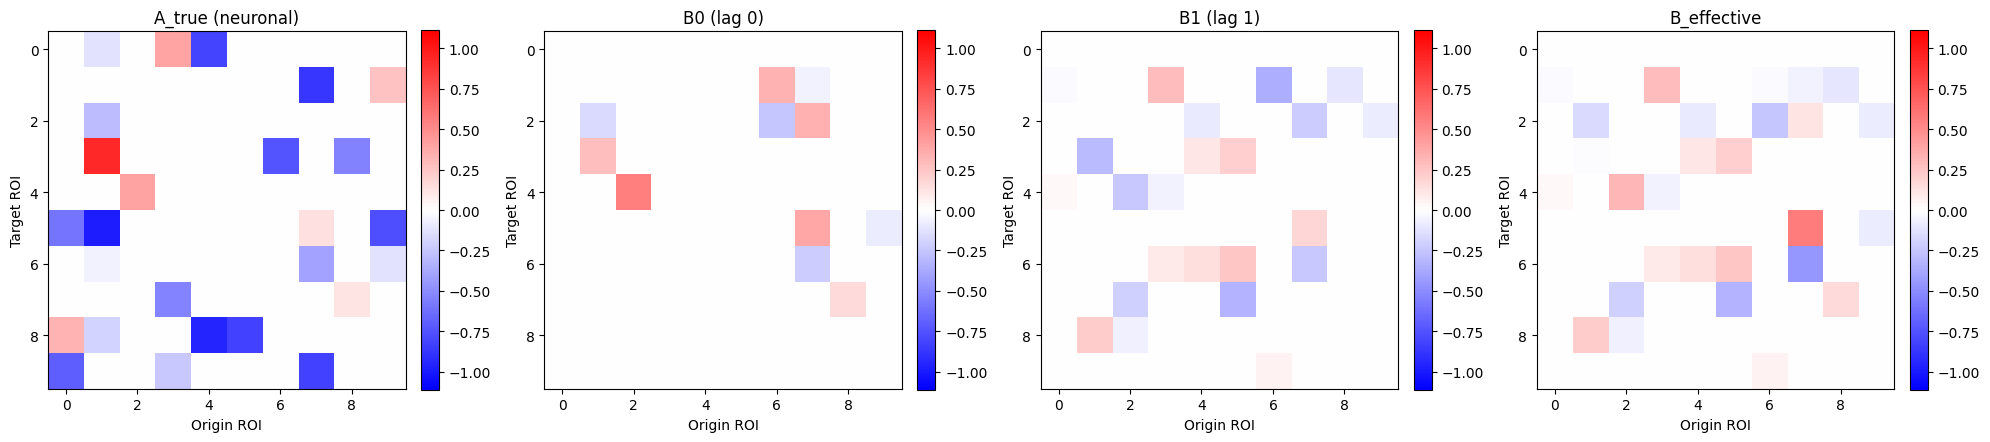

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# --- Cargar matriz de adyacencia neuronal verdadera ---
A_true = np.load(f"{base_path}/A_true.npy")

# --- Visualizar cada lag ---
n_lags = len(B)
# Add A_true to the list of matrices to plot
mats_to_plot = [(f"B{i} (lag {i})", B[i]) for i in range(n_lags)]

# Assuming A_true is loaded in a previous cell
# You might want to add error handling if A_true is not defined
if 'A_true' in locals() and A_true is not None:
    mats_to_plot.insert(0, ("A_true (neuronal)", A_true)) # Add A_true at the beginning

# Add B_effective to the list of matrices to plot
if 'B_effective' in locals() and B_effective is not None:
    mats_to_plot.append(("B_effective", B_effective))

n_mats = len(mats_to_plot) # Update the number of matrices
fig, axes = plt.subplots(1, n_mats, figsize=(5 * n_mats, 5))

if n_mats == 1: # Handle the case of a single subplot
    axes = [axes]

# Determine global color scale
v = max(np.max(np.abs(M)) for _, M in mats_to_plot)
v = 1.0 if v == 0 else v

for i, (title, M) in enumerate(mats_to_plot):
    ax = axes[i]
    # Set the diagonal to zero
    M_no_diag = M.copy()
    np.fill_diagonal(M_no_diag, 0)

    im = ax.imshow(M_no_diag, cmap='bwr',
                   vmin=-v, # Use global vmin
                   vmax=v)   # Use global vmax
    ax.set_title(title)
    ax.set_xlabel("Origin ROI")
    ax.set_ylabel("Target ROI")
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

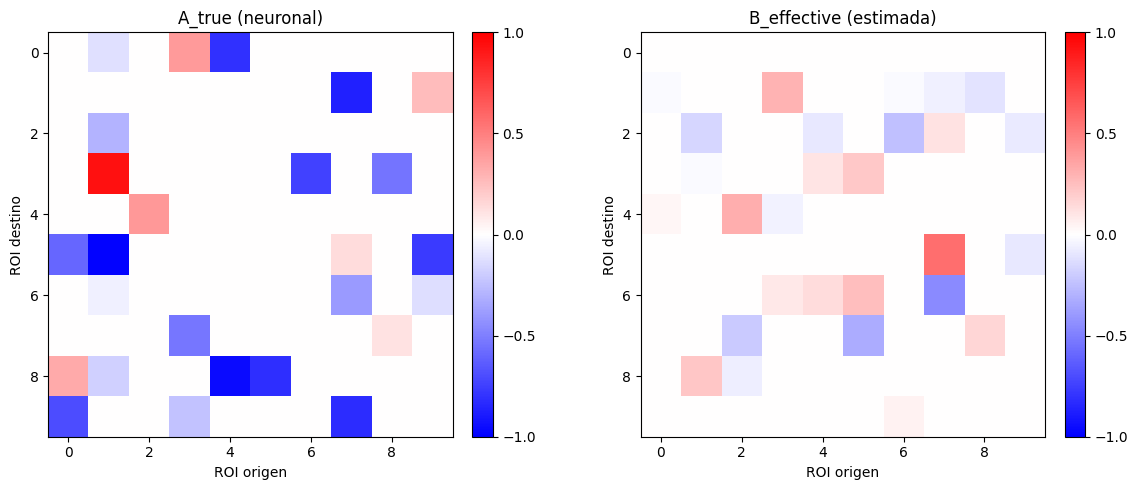

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# --- Cargar matrices ---
base_path = "/content/drive/MyDrive/Balloon"
A_true = np.load(f"{base_path}/A_true.npy")
B_effective = np.load(f"{base_path}/B_effective_factual.npy")

# --- Visualizar A_true y B_effective ---
mats_to_plot = [
    ("A_true (neuronal)", A_true),
    ("B_effective (estimada)", B_effective)
]

n_mats = len(mats_to_plot)
fig, axes = plt.subplots(1, n_mats, figsize=(6 * n_mats, 5))

if n_mats == 1:
    axes = [axes]

# Determine global color scale (setting it to -1 to 1 for requested ticks)
v_min_fixed = -1.0
v_max_fixed = 1.0

for i, (title, M) in enumerate(mats_to_plot):
    ax = axes[i]
    # Set the diagonal to zero for better visualization of connections
    M_no_diag = M.copy()
    np.fill_diagonal(M_no_diag, 0)

    im = ax.imshow(M_no_diag, cmap='bwr',
                   vmin=v_min_fixed,
                   vmax=v_max_fixed)
    ax.set_title(title)
    ax.set_xlabel("ROI origen")
    ax.set_ylabel("ROI destino")
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04, ticks=[-1, -0.5, 0, 0.5, 1])

plt.tight_layout()
plt.show()

Umbral óptimo (por F1-score): 0.1472


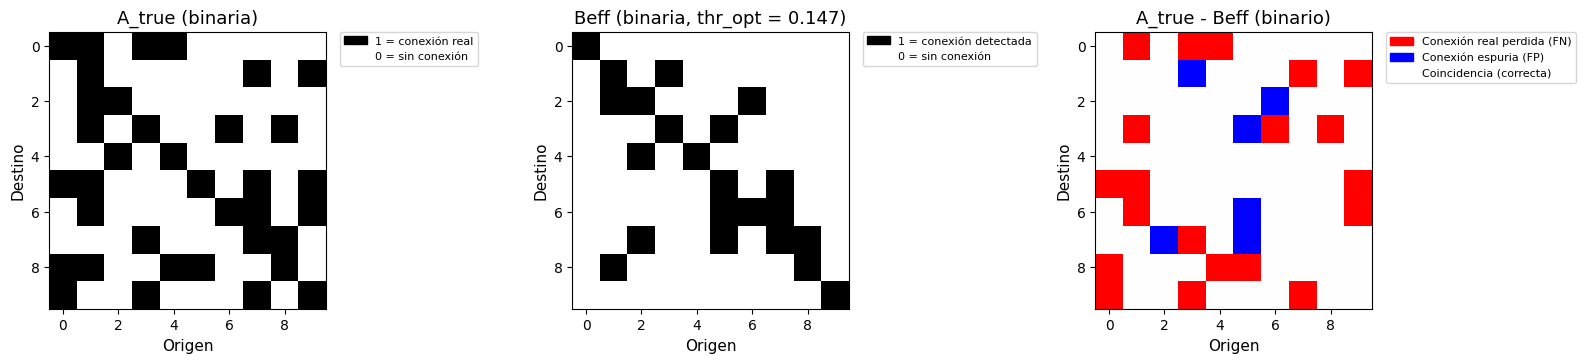

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.metrics import f1_score

# ---------------------------------------------------
# Cargar matrices
# ---------------------------------------------------
base_path = "/content/drive/MyDrive/Balloon"
A = np.load(f"{base_path}/A_true.npy")
Beff = np.load(f"{base_path}/B_effective_factual.npy")
assert A.shape == Beff.shape, "Las matrices deben tener el mismo tamaño"

# ---------------------------------------------------
# Convertir A_true a binaria
# ---------------------------------------------------
A_bin = (np.abs(A) > 0).astype(int)
truth = A_bin.flatten()

# ---------------------------------------------------
# Calcular umbral óptimo (max F1)
# ---------------------------------------------------
vals = np.abs(Beff.flatten())
thr_grid = np.linspace(np.percentile(vals, 5), np.percentile(vals, 95), 100)
f1_scores = []

for thr in thr_grid:
    pred = (vals >= thr).astype(int)
    f1_scores.append(f1_score(truth, pred))

thr_opt = thr_grid[np.argmax(f1_scores)]
print(f"Umbral óptimo (por F1-score): {thr_opt:.4f}")

# Binarizar Beff con thr óptimo
B_bin = (np.abs(Beff) >= thr_opt).astype(int)

# ---------------------------------------------------
# Diferencia estructural
# ---------------------------------------------------
diff_bin = A_bin - B_bin  # 1 = pérdida (FN), -1 = espuria (FP), 0 = correcta

# ---------------------------------------------------
# Figura con tres paneles más grandes
# ---------------------------------------------------
fig, axes = plt.subplots(1, 3, figsize=(16, 5))  # <-- figura más grande

# ---------- Panel 1: A_true ----------
im0 = axes[0].imshow(A_bin, cmap="Greys", interpolation="nearest")
axes[0].set_title("A_true (binaria)", fontsize=13)
axes[0].set_xlabel("Origen", fontsize=11)
axes[0].set_ylabel("Destino", fontsize=11)
axes[0].legend(
    handles=[
        mpatches.Patch(color='black', label='1 = conexión real'),
        mpatches.Patch(color='white', label='0 = sin conexión')],
    bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.,
    fontsize=8  # <-- texto más pequeño
)

# ---------- Panel 2: Beff binaria ----------
im1 = axes[1].imshow(B_bin, cmap="Greys", interpolation="nearest")
axes[1].set_title(f"Beff (binaria, thr_opt = {thr_opt:.3f})", fontsize=13)
axes[1].set_xlabel("Origen", fontsize=11)
axes[1].set_ylabel("Destino", fontsize=11)
axes[1].legend(
    handles=[
        mpatches.Patch(color='black', label='1 = conexión detectada'),
        mpatches.Patch(color='white', label='0 = sin conexión')],
    bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.,
    fontsize=8
)

# ---------- Panel 3: A - Beff ----------
im2 = axes[2].imshow(diff_bin, cmap="bwr", interpolation="nearest", vmin=-1, vmax=1)
axes[2].set_title("A_true - Beff (binario)", fontsize=13)
axes[2].set_xlabel("Origen", fontsize=11)
axes[2].set_ylabel("Destino", fontsize=11)
axes[2].legend(
    handles=[
        mpatches.Patch(color='red', label='Conexión real perdida (FN)'),
        mpatches.Patch(color='blue', label='Conexión espuria (FP)'),
        mpatches.Patch(color='white', label='Coincidencia (correcta)')],
    bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.,
    fontsize=8
)

plt.tight_layout()
plt.show()

# DCM con varlingam con lasso

## Intento 6

In [10]:
import numpy as np

file_path = '/content/drive/MyDrive/Balloon/X_neur.npy'
X_neur = np.load(file_path)
file_path = '/content/drive/MyDrive/Balloon/C_inst.npy'
C_inst = np.load(file_path)
file_path = '/content/drive/MyDrive/Balloon/B_lag.npy'
B_lag = np.load(file_path)
file_path = '/content/drive/MyDrive/Balloon/A_custom.npy'
A_custom = np.load(file_path)
file_path = '/content/drive/MyDrive/Balloon/X_bold.npy'
X_bold = np.load(file_path)
print(f"Archivo '{file_path}' cargado. Shape: {X_neur.shape}")

Archivo '/content/drive/MyDrive/Balloon/X_bold.npy' cargado. Shape: (3000, 10)


In [11]:
from sklearn.preprocessing import StandardScaler

# Instantiate StandardScaler
scaler_neur = StandardScaler()

# Apply fit_transform to X_neur and store the standardized data
X_neur_z = scaler_neur.fit_transform(X_neur)

print(f"X_neur_z shape: {X_neur_z.shape}")
print(f"X_neur_z first 5 rows:\n{X_neur_z[:5]}")

X_neur_z shape: (3000, 10)
X_neur_z first 5 rows:
[[-0.01159986 -0.02417632 -0.04597175 -0.02468985 -0.05887672 -0.0322624
  -0.02380965 -0.0391525  -0.020559   -0.005191  ]
 [-0.01159986 -0.02417632 -0.04597175 -0.02468985 -0.05887672 -0.0322624
  -0.02380965 -0.0391525  -0.020559   -0.005191  ]
 [-0.01159986 -0.02417632 -0.04597175 -0.02468985 -0.05887672 -0.0322624
  -0.02380965 -0.0391525  -0.020559   -0.005191  ]
 [-0.01159986 -0.02417632 -0.04597175 -0.02468985 -0.05887672 -0.0322624
  -0.02380965 -0.0391525  -0.020559   -0.005191  ]
 [-0.01159986 -0.02417632 -0.04597175 -0.02468985 -0.05887672 -0.0322624
  -0.02380965 -0.0391525  -0.020559   -0.005191  ]]


In [12]:
model_neuronal = VARLiNGAM(lags=1, prune=True, alpha_lasso=0.055)
model_neuronal.fit(X_neur_z)

# Extract adjacency matrices
B_neuronal = model_neuronal.adjacency_matrices_  # [B0, B1, ...]

print("VARLiNGAM model fitted for X_neur_z.")
print(f"B0 (neuronal) shape: {B_neuronal[0].shape}")
print(f"Number of lags estimated: {len(B_neuronal)-1}")

VARLiNGAM model fitted for X_neur_z.
B0 (neuronal) shape: (10, 10)
Number of lags estimated: 1


In [13]:
B_effective_neuronal = sum(B_neuronal)

# Save B0_neuronal
np.save(f"{base_path}/B0_neuronal.npy", B_neuronal[0])

# Save B_effective_neuronal
np.save(f"{base_path}/B_effective_neuronal.npy", B_effective_neuronal)

print("B0_neuronal and B_effective_neuronal saved successfully.")

B0_neuronal and B_effective_neuronal saved successfully.


In [14]:
A_true = np.load(f"{base_path}/A_true.npy")
print(f"A_true loaded successfully. Shape: {A_true.shape}")

A_true loaded successfully. Shape: (10, 10)


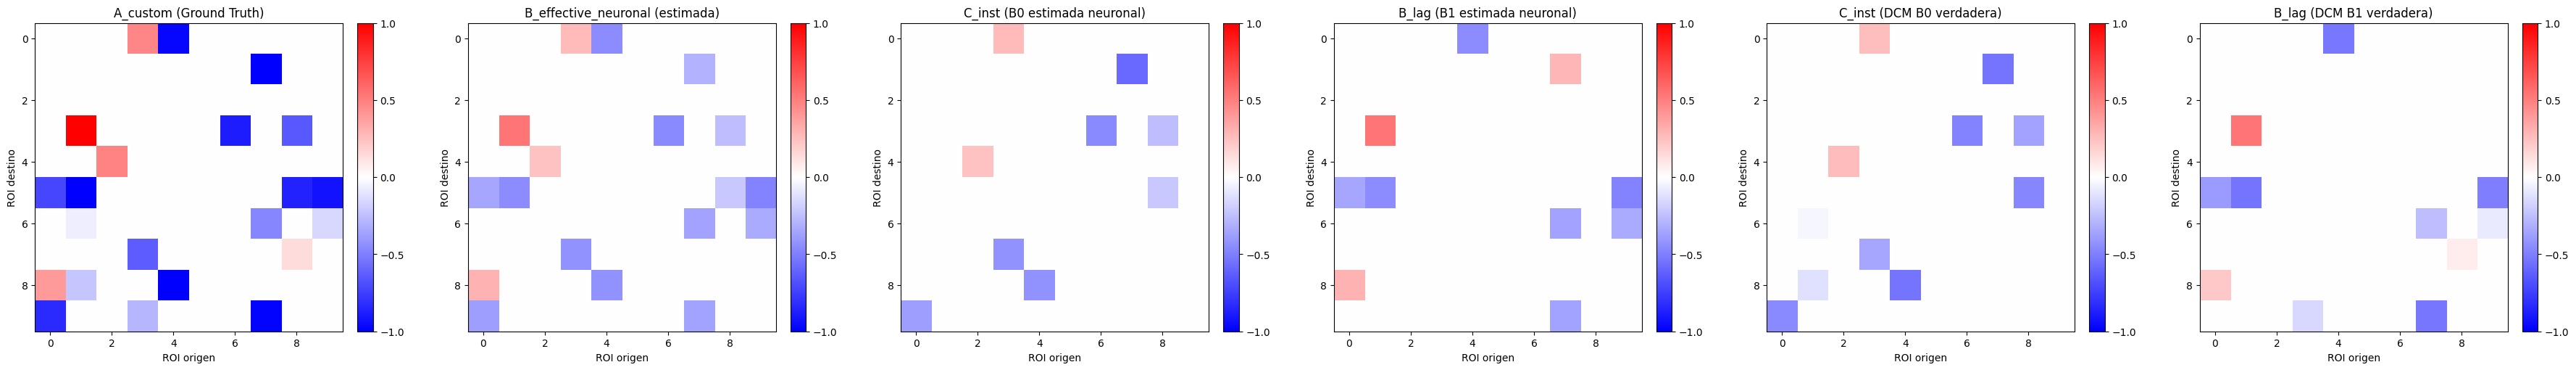

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# --- Visualizar A_custom, B_effective_neuronal, C_inst y B_lag ---

# List of matrices to plot with specific labels
mats_to_plot = [
    ("A_custom (Ground Truth)", A_custom),
    ("B_effective_neuronal (estimada)", B_effective_neuronal),
    ("C_inst (B0 estimada neuronal)", B_neuronal[0]),
    ("B_lag (B1 estimada neuronal)", B_neuronal[1]),
    ("C_inst (DCM B0 verdadera)", C_inst),
    ("B_lag (DCM B1 verdadera)", B_lag)
]

n_mats = len(mats_to_plot)
fig, axes = plt.subplots(1, n_mats, figsize=(6 * n_mats, 5))

if n_mats == 1:
    axes = [axes]

# Determine global color scale (setting it to -1 to 1 for requested ticks)
v_min_fixed = -1.0
v_max_fixed = 1.0

for i, (title, M) in enumerate(mats_to_plot):
    ax = axes[i]
    # Set the diagonal to zero for better visualization of connections
    M_no_diag = M.copy()
    np.fill_diagonal(M_no_diag, 0)

    im = ax.imshow(M_no_diag, cmap='bwr',
                   vmin=v_min_fixed,
                   vmax=v_max_fixed)
    ax.set_title(title)
    ax.set_xlabel("ROI origen")
    ax.set_ylabel("ROI destino")
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04, ticks=[-1, -0.5, 0, 0.5, 1])

plt.tight_layout()
plt.show()

/tmp/ipython-input-2304535952.py:60: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.92, 0.95])


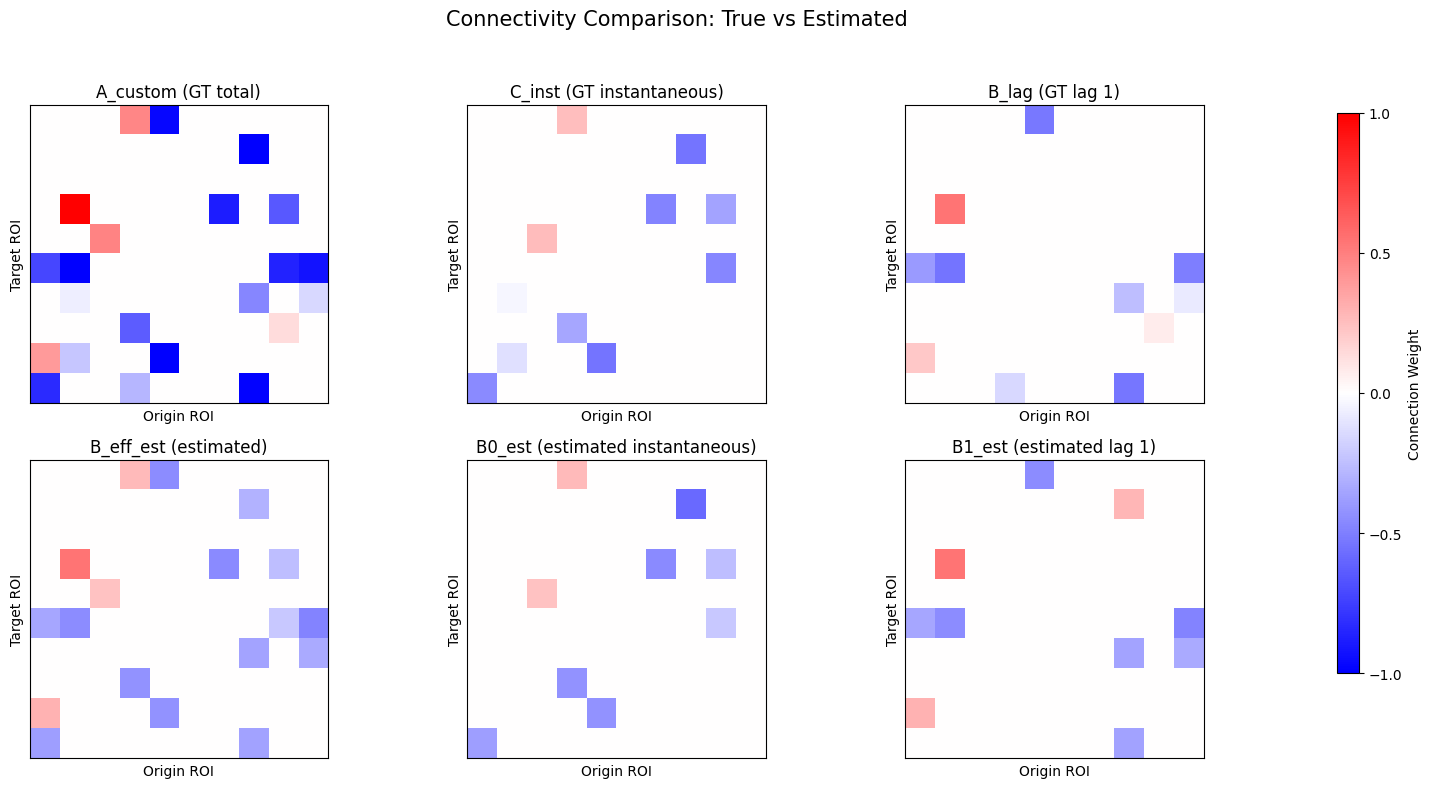

In [16]:
import matplotlib.pyplot as plt
import numpy as np

def zero_diag(M):
    M = M.copy()
    np.fill_diagonal(M, 0)
    return M

# ----------------------------
# REAL MATRICES (top row)
# ----------------------------
real_mats = [
    ("A_custom (GT total)",       zero_diag(A_custom)),
    ("C_inst (GT instantaneous)",   zero_diag(C_inst)),
    ("B_lag (GT lag 1)",          zero_diag(B_lag))
]

# ----------------------------
# ESTIMATED MATRICES (bottom row)
# ----------------------------
estimated_mats = [
    ("B_eff_est (estimated)",      zero_diag(B_effective_neuronal)),
    ("B0_est (estimated instantaneous)", zero_diag(B_neuronal[0])),
    ("B1_est (estimated lag 1)",       zero_diag(B_neuronal[1]))
]

# ----------------------------
# PLOT 2x3
# ----------------------------
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
vmin, vmax = -1.0, 1.0   # fixed scale

# --- row 1: ground truth ---
for ax, (title, M) in zip(axes[0], real_mats):
    im = ax.imshow(M, cmap='bwr', vmin=vmin, vmax=vmax)
    ax.set_title(title, fontsize=12)
    ax.set_xlabel("Origin ROI", fontsize=10)
    ax.set_ylabel("Target ROI", fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])

# --- row 2: estimated ---
for ax, (title, M) in zip(axes[1], estimated_mats):
    im = ax.imshow(M, cmap='bwr', vmin=vmin, vmax=vmax)
    ax.set_title(title, fontsize=12)
    ax.set_xlabel("Origin ROI", fontsize=10)
    ax.set_ylabel("Target ROI", fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])

# ----------------------------
# SINGLE COLOR BAR TO THE RIGHT
# ----------------------------
fig.subplots_adjust(right=0.92)
cbar_ax = fig.add_axes([0.94, 0.15, 0.015, 0.7])  # [left, bottom, width, height]
cbar = fig.colorbar(im, cax=cbar_ax, ticks=[-1, -0.5, 0, 0.5, 1])
cbar.ax.set_ylabel("Connection Weight", rotation=90)

plt.suptitle("Connectivity Comparison: True vs Estimated", fontsize=15)
plt.tight_layout(rect=[0, 0, 0.92, 0.95])
plt.show()

## Intento 7

In [17]:
from sklearn.preprocessing import StandardScaler

# Instantiate StandardScaler
scaler_bold = StandardScaler()

# Apply fit_transform to X_bold and store the standardized data
X_bold_z = scaler_bold.fit_transform(X_bold)

print(f"X_bold_z shape: {X_bold_z.shape}")
print(f"X_bold_z first 5 rows:\n{X_bold_z[:5]}")

X_bold_z shape: (3000, 10)
X_bold_z first 5 rows:
[[-0.03699405 -0.05709046 -0.09481773 -0.0622403  -0.1110578  -0.05234315
  -0.06793403 -0.08064025 -0.03504764 -0.01954061]
 [-0.03699405 -0.05709046 -0.09481773 -0.0622403  -0.1110578  -0.05234315
  -0.06793403 -0.08064025 -0.03504764 -0.01954061]
 [-0.03699405 -0.05709046 -0.09481773 -0.0622403  -0.1110578  -0.05234315
  -0.06793403 -0.08064025 -0.03504764 -0.01954061]
 [-0.03699405 -0.05709046 -0.09481773 -0.0622403  -0.1110578  -0.05234315
  -0.06793403 -0.08064025 -0.03504764 -0.01954061]
 [-0.03699405 -0.05709046 -0.09481773 -0.0622403  -0.1110578  -0.05234315
  -0.06793403 -0.08064025 -0.03504764 -0.01954061]]


In [18]:
model_bold = VARLiNGAM(lags=1, prune=True, alpha_lasso=0.002)
model_bold.fit(X_bold_z)

# Extract adjacency matrices
B_bold = model_bold.adjacency_matrices_  # [B0, B1, ...]

print("VARLiNGAM model fitted for X_bold_z.")
print(f"B0 (BOLD) shape: {B_bold[0].shape}")
print(f"Number of lags estimated: {len(B_bold)-1}")

VARLiNGAM model fitted for X_bold_z.
B0 (BOLD) shape: (10, 10)
Number of lags estimated: 1


In [19]:
B_effective_bold = sum(B_bold)

# Save B0_bold
np.save(f"{base_path}/B0_bold.npy", B_bold[0])

# Save B_effective_bold
np.save(f"{base_path}/B_effective_bold.npy", B_effective_bold)

print("B0_bold and B_effective_bold saved successfully.")

B0_bold and B_effective_bold saved successfully.


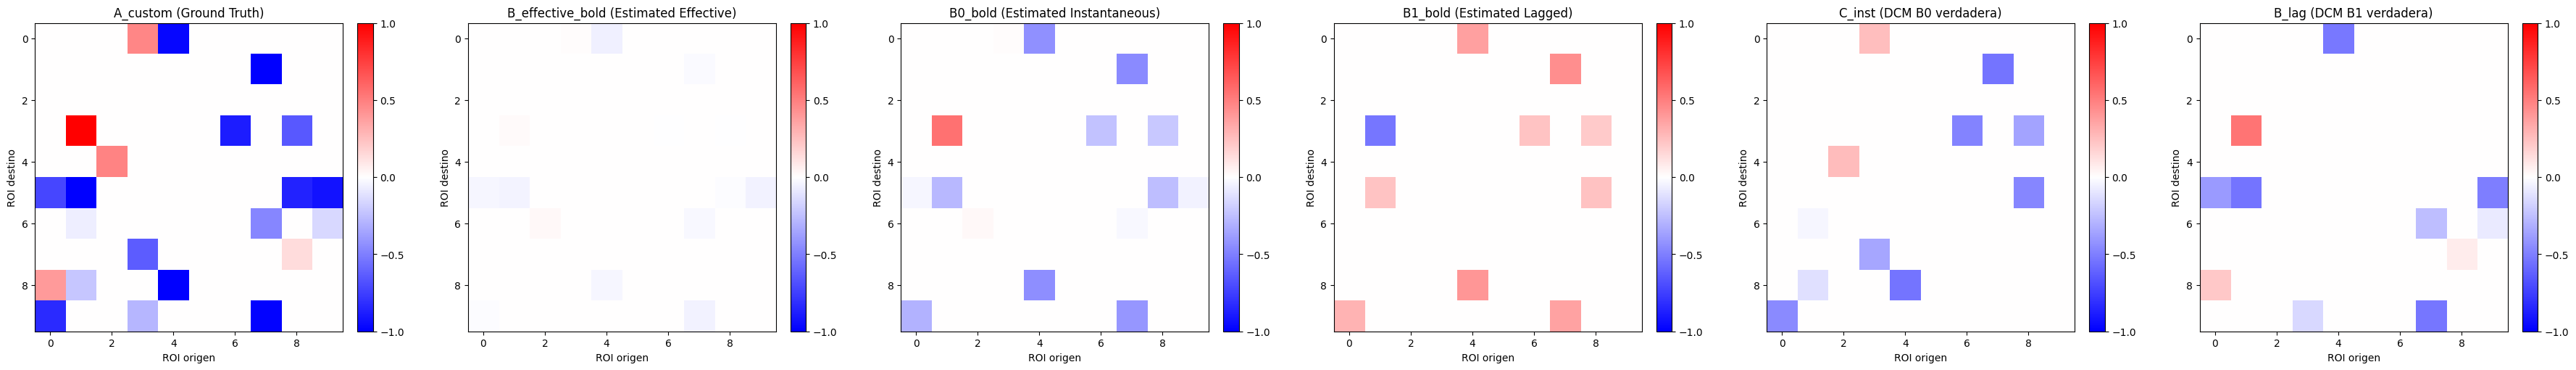

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# List of matrices to plot with specific labels
mats_to_plot = [
    ("A_custom (Ground Truth)", A_custom),
    ("B_effective_bold (Estimated Effective)", B_effective_bold),
    ("B0_bold (Estimated Instantaneous)", B_bold[0]),
    ("B1_bold (Estimated Lagged)", B_bold[1]),
    ("C_inst (DCM B0 verdadera)", C_inst),
    ("B_lag (DCM B1 verdadera)", B_lag)
]

n_mats = len(mats_to_plot)
fig, axes = plt.subplots(1, n_mats, figsize=(6 * n_mats, 5))

if n_mats == 1:
    axes = [axes]

# Determine global color scale (setting it to -1 to 1 for requested ticks)
v_min_fixed = -1.0
v_max_fixed = 1.0

for i, (title, M) in enumerate(mats_to_plot):
    ax = axes[i]
    # Set the diagonal to zero for better visualization of connections
    M_no_diag = M.copy()
    np.fill_diagonal(M_no_diag, 0)

    im = ax.imshow(M_no_diag, cmap='bwr',
                   vmin=v_min_fixed,
                   vmax=v_max_fixed)
    ax.set_title(title)
    ax.set_xlabel("ROI origen")
    ax.set_ylabel("ROI destino")
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04, ticks=[-1, -0.5, 0, 0.5, 1])

plt.tight_layout()
plt.show()

B0_bold shape: (10, 10)
B1_bold shape: (10, 10)
B_effective_bold shape: (10, 10)


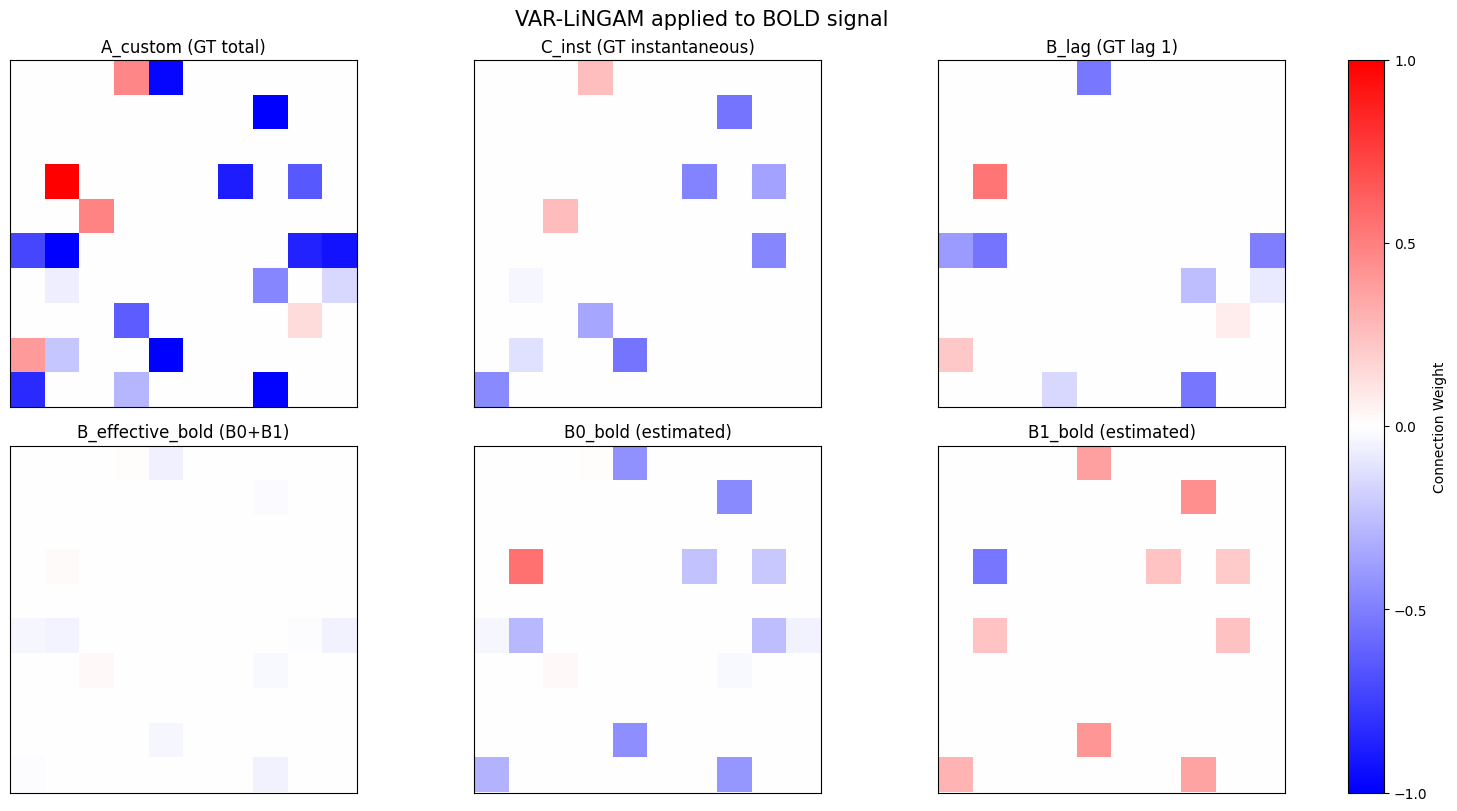

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# ========= 1) CARGAR MATRICES Y SEÑAL BOLD =========
base_path = "/content/drive/MyDrive/Balloon"

A_custom = np.load(f"{base_path}/A_custom.npy")
C_inst   = np.load(f"{base_path}/C_inst.npy")
B_lag    = np.load(f"{base_path}/B_lag.npy")
X_bold   = np.load(f"{base_path}/X_bold.npy")

# Estandarizar BOLD
X_bold_z = StandardScaler().fit_transform(X_bold)

# ========= 2) AJUSTAR VAR-LiNGAM (INTENTO 7) =========
model_bold = VARLiNGAM(lags=1, prune=True, alpha_lasso=0.002)
model_bold.fit(X_bold_z)

B_bold = model_bold.adjacency_matrices_
B0_bold = B_bold[0]
B1_bold = B_bold[1]
B_effective_bold = B0_bold + B1_bold

print("B0_bold shape:", B0_bold.shape)
print("B1_bold shape:", B1_bold.shape)
print("B_effective_bold shape:", B_effective_bold.shape)

# ========= 3) FUNCION AUXILIAR =========
def zero_diag(M):
    M = M.copy()
    np.fill_diagonal(M, 0)
    return M

# ========= 4) MATRICES A PLOTEAR =========
real_mats = [
    ("A_custom (GT total)",       zero_diag(A_custom)),
    ("C_inst (GT instantaneous)",   zero_diag(C_inst)),
    ("B_lag (GT lag 1)",          zero_diag(B_lag)),
]

estimated_mats = [
    ("B_effective_bold (B0+B1)",  zero_diag(B_effective_bold)),
    ("B0_bold (estimated)",        zero_diag(B0_bold)),
    ("B1_bold (estimated)",        zero_diag(B1_bold)),
]

# ========= 5) FIGURA 2x3 CON UNA COLORBAR =========
fig = plt.figure(figsize=(15, 8), constrained_layout=True)
gs = fig.add_gridspec(2, 4, width_ratios=[1, 1, 1, 0.08])

vmin, vmax = -1, 1

# Fila 1: reales
for col, (title, M) in enumerate(real_mats):
    ax = fig.add_subplot(gs[0, col])
    im = ax.imshow(M, cmap="bwr", vmin=vmin, vmax=vmax)
    ax.set_title(title)
    ax.set_xticks([])
    ax.set_yticks([])

# Fila 2: estimadas
for col, (title, M) in enumerate(estimated_mats):
    ax = fig.add_subplot(gs[1, col])
    im = ax.imshow(M, cmap="bwr", vmin=vmin, vmax=vmax)
    ax.set_title(title)
    ax.set_xticks([])
    ax.set_yticks([])

# Colorbar única
cax = fig.add_subplot(gs[:, 3])
cbar = fig.colorbar(im, cax=cax, ticks=[-1, -0.5, 0, 0.5, 1])
cbar.ax.set_ylabel("Connection Weight", rotation=90)

plt.suptitle("VAR-LiNGAM applied to BOLD signal", fontsize=15)
plt.show()

## Intento 9 condeconvolucion


B0_dec shape: (10, 10)
B1_dec shape: (10, 10)
B_effective_dec shape: (10, 10)


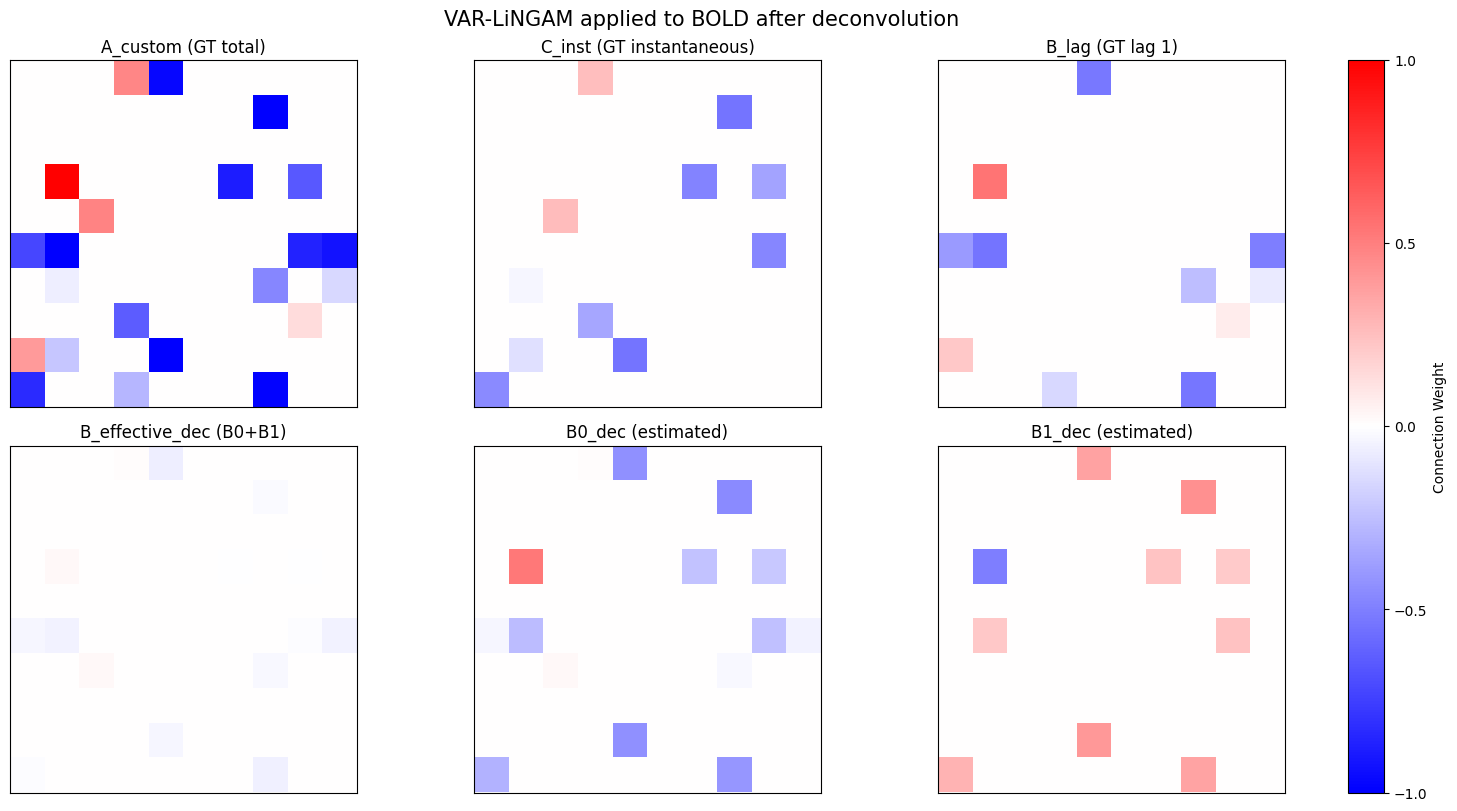

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# ========= 1) CARGAR MATRICES Y SEÑAL BOLD =========
base_path = "/content/drive/MyDrive/Balloon"

A_custom = np.load(f"{base_path}/A_custom.npy")
C_inst   = np.load(f"{base_path}/C_inst.npy")
B_lag    = np.load(f"{base_path}/B_lag.npy")
X_bold   = np.load(f"{base_path}/X_bold.npy")

# ========= 2) DECONVOLUCIÓN (BOLD -> "neuronal estimada") =========
TR = 2.0          # <-- ajusta a tu TR real
snr_wiener = 5.0  # <-- prueba 2,5,10

def spm_hrf(tr, length=32.0):
    dt = tr
    t = np.arange(0, length, dt)

    a1, a2 = 6, 16
    b1, b2 = 1, 1
    c = 1/6

    from math import gamma
    def gamma_pdf(tt, a, b):
        return (tt**(a-1) * np.exp(-tt/b)) / (gamma(a) * (b**a))

    h = gamma_pdf(t, a1, b1) - c * gamma_pdf(t, a2, b2)
    h = h / (np.sum(h) + 1e-12)
    return h

def wiener_deconv_1d(y, h, snr=5.0):
    T = len(y)
    L = len(h)
    nfft = int(2**np.ceil(np.log2(T + L - 1)))

    Y = np.fft.rfft(y, n=nfft)
    H = np.fft.rfft(h, n=nfft)

    X = (np.conj(H) / (np.abs(H)**2 + (1.0/max(snr,1e-12)))) * Y
    x = np.fft.irfft(X, n=nfft)[:T]
    return x

def apply_wiener_deconvolution_matrix(X_bold, hrf, snr=5.0):
    T, D = X_bold.shape
    X_dec = np.zeros_like(X_bold, dtype=float)
    for d in range(D):
        X_dec[:, d] = wiener_deconv_1d(X_bold[:, d], hrf, snr=snr)
    return X_dec

hrf = spm_hrf(TR)
X_neur_dec = apply_wiener_deconvolution_matrix(X_bold, hrf, snr=snr_wiener)

# Estandarizar señal deconvolucionada (igual que haces con BOLD)
X_neur_dec_z = StandardScaler().fit_transform(X_neur_dec)

# ========= 3) AJUSTAR VAR-LiNGAM SOBRE DECONVOLUCIÓN =========
model_dec = VARLiNGAM(lags=1, prune=True, alpha_lasso=0.002)  # ajusta si quieres
model_dec.fit(X_neur_dec_z)

B_dec = model_dec.adjacency_matrices_
B0_dec = B_dec[0]
B1_dec = B_dec[1]
B_effective_dec = B0_dec + B1_dec

print("B0_dec shape:", B0_dec.shape)
print("B1_dec shape:", B1_dec.shape)
print("B_effective_dec shape:", B_effective_dec.shape)

# ========= 4) FUNCION AUXILIAR =========
def zero_diag(M):
    M = M.copy()
    np.fill_diagonal(M, 0)
    return M

# ========= 5) MATRICES A PLOTEAR =========
real_mats = [
    ("A_custom (GT total)",         zero_diag(A_custom)),
    ("C_inst (GT instantaneous)",   zero_diag(C_inst)),
    ("B_lag (GT lag 1)",            zero_diag(B_lag)),
]

estimated_mats = [
    ("B_effective_dec (B0+B1)",     zero_diag(B_effective_dec)),
    ("B0_dec (estimated)",          zero_diag(B0_dec)),
    ("B1_dec (estimated)",          zero_diag(B1_dec)),
]

# ========= 6) FIGURA 2x3 CON UNA COLORBAR (MISMO ESTILO) =========
fig = plt.figure(figsize=(15, 8), constrained_layout=True)
gs = fig.add_gridspec(2, 4, width_ratios=[1, 1, 1, 0.08])

vmin, vmax = -1, 1

# Fila 1: reales
for col, (title, M) in enumerate(real_mats):
    ax = fig.add_subplot(gs[0, col])
    im = ax.imshow(M, cmap="bwr", vmin=vmin, vmax=vmax)
    ax.set_title(title)
    ax.set_xticks([])
    ax.set_yticks([])

# Fila 2: estimadas
for col, (title, M) in enumerate(estimated_mats):
    ax = fig.add_subplot(gs[1, col])
    im = ax.imshow(M, cmap="bwr", vmin=vmin, vmax=vmax)
    ax.set_title(title)
    ax.set_xticks([])
    ax.set_yticks([])

# Colorbar única
cax = fig.add_subplot(gs[:, 3])
cbar = fig.colorbar(im, cax=cax, ticks=[-1, -0.5, 0, 0.5, 1])
cbar.ax.set_ylabel("Connection Weight", rotation=90)

plt.suptitle("VAR-LiNGAM applied to BOLD after deconvolution", fontsize=15)
plt.show()